In [2]:
import os
import sys
from datetime import datetime
from meteostat import Hourly
from pyspark.sql import SparkSession
import pyspark.pandas as ps

os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

In [3]:
# Set time period
start = datetime(1973, 1, 1)
end = datetime(2023, 10, 15)
# Get hourly data
data = Hourly('72219', start, end)
data = data.fetch()

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv(r'D:\Hamza Bouajila\3IDSD SD\Spark\TP\Data Minupulation Spark\chicago_crime_2016.csv',header=True, inferSchema=True)

In [5]:
df.show()

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+-------------+
|      ID|Case_Number|                Date|               Block|IUCR|       Primar_yType|         Description|Location_Description|Arrest|Domestic|Beat|District|Ward|Community_Area|FBI_Code|    Latitude|    Longitude|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+-------------+
|10402434|   HZ138921|01/08/2016 12:00:...|    004XX W 126TH PL|0610|           BURGLARY|      FORCIBLE ENTRY|           RESIDENCE| false|   false| 523|       5|   9|            53|      05|        NULL|         NULL|
|10402492|   HZ133048|01/28/2016 12:00:...|    059XX W HURON ST|0620|           BURGLARY|      UNLAWFUL ENTRY|           RESIDEN

In [19]:
from pyspark.sql.functions import to_timestamp
df2 = df.withColumn("Date", to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))

In [20]:
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case_Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primar_yType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location_Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community_Area: integer (nullable = true)
 |-- FBI_Code: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



array([10402434])

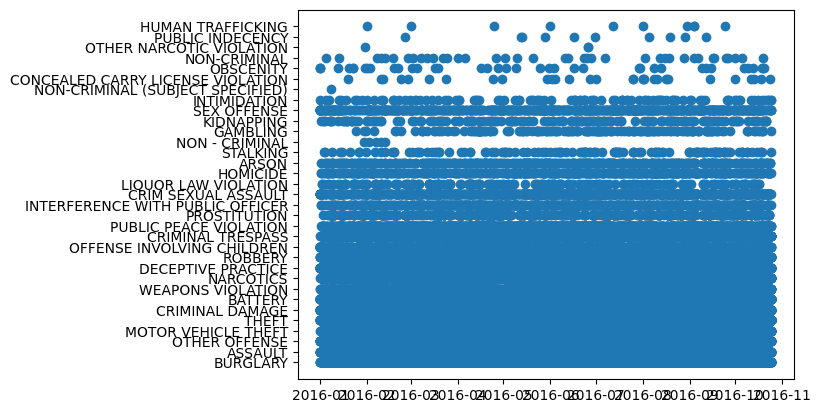

In [38]:
import matplotlib.pyplot as plt

x = df2.select("Date").rdd.flatMap(lambda x: x).collect()
y = df2.select("Primar_yType").group .rdd.flatMap(lambda x: x).collect()
plt.scatter(x, y)
plt.show()


In [105]:
from pyspark.sql.types import *

In [63]:
# Import Meteostat library
from meteostat import Stations

# Get nearby weather stations
stations = Stations()
stations = stations.nearby(34.8344640, 10.7697791)

# Print DataFrame
dff = stations.fetch(5000)
places = dff[dff.country  =="TN"].loc[:,['latitude','longitude','name','country','region',"elevation"]]

In [59]:
# Importer les modules nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
import requests
import json
# Créer une session Spark
# spark = SparkSession.builder.appName("KafkaPySparkOpenWeather").getOrCreate()
lat = 34.8344640
lon = 10.7697791
# part = "minutely,hourly,daily,alerts"
# api_url = f"http://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={part}&appid=7b8272ddd05780cc2edbcefd63a4bd08"
api_url = f"https://api.openweathermap.org/data/2.5/weather?q=Tunisia&appid=e322315e108859a861f72b7d7790006b"

# Définir une fonction pour envoyer une requête à l'API et publier la réponse dans un sujet Kafka
def send_request_to_api(api_url) -> json:
  # Envoyer une requête GET à l'API OpenWeather
  response = requests.get(api_url)
  # Vérifier le statut de la réponse
  if response.status_code == 200:
    # Extraire les données JSON de la réponse
    data = response.json()
    return data
  else:
    return {f"Error: {response.status_code}"}


In [63]:
DF[0]

{'coord': {'lon': 9, 'lat': 34},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01d'}],
 'base': 'stations',
 'main': {'temp': 304.04,
  'feels_like': 302.07,
  'temp_min': 304.04,
  'temp_max': 304.04,
  'pressure': 1010,
  'humidity': 18,
  'sea_level': 1010,
  'grnd_level': 1007},
 'visibility': 10000,
 'wind': {'speed': 5.76, 'deg': 258, 'gust': 6.74},
 'clouds': {'all': 0},
 'dt': 1698411511,
 'sys': {'type': 1,
  'id': 1197,
  'country': 'TN',
  'sunrise': 1698385111,
  'sunset': 1698424624},
 'timezone': 3600,
 'id': 2464461,
 'name': 'Tunisia',
 'cod': 200}

In [61]:
from pyspark.sql import SparkSession as sc
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import time

while True:
    try:
        data = send_request_to_api(api_url)
        time.sleep(5)
        spark = SparkSession.builder.appName("OpenWeatherStream").getOrCreate()

        schema = StructType([
            StructField("country", StringType(), True),
            StructField("temperature", DoubleType(), True),
            StructField("humidity", DoubleType(), True),
            StructField("pressure", DoubleType(), True)
        ])
        
        df = spark.createDataFrame(data)
        df.show()
        # df = df.select(from_json(col("value"), schema).alias("data")).select("data.*")

        # Displaying the streaming data in console
        df.writeStream.outputMode("append").format("console").start().awaitTermination()
    except Exception as e:
        print(e)
        continue


[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.
[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.
[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.
[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.
[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.
[CANNOT_ACCEPT_OBJECT_IN_TYPE] `StructType` can not accept object `coord` in type `str`.


KeyboardInterrupt: 

In [90]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.appName("OpenWeatherStream").getOrCreate()
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()

# schema = StructType([
#     StructField("country", StringType(), True),
#     StructField("temperature", DoubleType(), True),
#     StructField("humidity", DoubleType(), True),
#     StructField("pressure", DoubleType(), True)
# ])
data_dict = {
             "country":data["sys"]["country"],
             "temperature":data["main"]["temp"],
             "humidity":data["main"]["humidity"],
             "pressure":data["main"]["pressure"]
             }
data_json = json.dumps(data_dict)
print(data_json)
df = spark.read.json(sc.parallelize([data_json]))
df.show()
print(df.printSchema())


{"country": "TN", "temperature": 304.04, "humidity": 18, "pressure": 1010}
+-------+--------+--------+-----------+
|country|humidity|pressure|temperature|
+-------+--------+--------+-----------+
|     TN|      18|    1010|     304.04|
+-------+--------+--------+-----------+

root
 |-- country: string (nullable = true)
 |-- humidity: long (nullable = true)
 |-- pressure: long (nullable = true)
 |-- temperature: double (nullable = true)

None


# Stremalit

In [5]:
import time  # to simulate a real time data, time loop

import numpy as np  # np mean, np random
import pandas as pd  # read csv, df manipulation
import plotly.express as px  # interactive charts
import streamlit as st  # 🎈 data web app development

st.set_page_config(
    page_title="Real-Time Data Science Dashboard",
    page_icon="✅",
    layout="wide",
)

# read csv from a github repo
dataset_url = "https://raw.githubusercontent.com/Lexie88rus/bank-marketing-analysis/master/bank.csv"

# read csv from a URL
@st.experimental_memo
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

df = get_data()

# dashboard title
st.title("Real-Time / Live Data Science Dashboard")

# top-level filters
job_filter = st.selectbox("Select the Job", pd.unique(df["job"]))

# creating a single-element container
placeholder = st.empty()

# dataframe filter
df = df[df["job"] == job_filter]

# near real-time / live feed simulation
for seconds in range(200):

    df["age_new"] = df["age"] * np.random.choice(range(1, 5))
    df["balance_new"] = df["balance"] * np.random.choice(range(1, 5))

    # creating KPIs
    avg_age = np.mean(df["age_new"])

    count_married = int(
        df[(df["marital"] == "married")]["marital"].count()
        + np.random.choice(range(1, 30))
    )

    balance = np.mean(df["balance_new"])

    with placeholder.container():

        # create three columns
        kpi1, kpi2, kpi3 = st.columns(3)

        # fill in those three columns with respective metrics or KPIs
        kpi1.metric(
            label="Age ⏳",
            value=round(avg_age),
            delta=round(avg_age) - 10,
        )
        
        kpi2.metric(
            label="Married Count 💍",
            value=int(count_married),
            delta=-10 + count_married,
        )
        
        kpi3.metric(
            label="A/C Balance ＄",
            value=f"$ {round(balance,2)} ",
            delta=-round(balance / count_married) * 100,
        )

        # create two columns for charts
        fig_col1, fig_col2 = st.columns(2)
        with fig_col1:
            st.markdown("### First Chart")
            fig = px.density_heatmap(
                data_frame=df, y="age_new", x="marital"
            )
            st.write(fig)
            
        with fig_col2:
            st.markdown("### Second Chart")
            fig2 = px.histogram(data_frame=df, x="age_new")
            st.write(fig2)

        st.markdown("### Detailed Data View")
        st.dataframe(df)
        time.sleep(1)

2023-11-16 23:22:14.074 
  command:

    streamlit run c:\Users\LENOVO\anaconda3\envs\spark\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2023-11-16 23:22:14.079 `st.experimental_memo` is deprecated. Please use the new command `st.cache_data` instead, which has the same behavior. More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
2023-11-16 23:22:14.081 No runtime found, using MemoryCacheStorageManager
2023-11-16 23:22:14.298 No runtime found, using MemoryCacheStorageManager


In [7]:
!streamlit run c:\Users\LENOVO\anaconda3\envs\spark\Lib\site-packages\ipykernel_launcher.py 

'streamlit' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
